Adam_with_reg Epoch 1/20 Loss: 3.6931
Adam_with_reg Epoch 2/20 Loss: 3.6886
Adam_with_reg Epoch 3/20 Loss: 3.6860
Adam_with_reg Epoch 4/20 Loss: 3.6868
Adam_with_reg Epoch 5/20 Loss: 3.6852
Adam_with_reg Epoch 6/20 Loss: 3.6829
Adam_with_reg Epoch 7/20 Loss: 3.6853
Adam_with_reg Epoch 8/20 Loss: 3.6798
Adam_with_reg Epoch 9/20 Loss: 3.6792
Adam_with_reg Epoch 10/20 Loss: 3.6777
Adam_with_reg Epoch 11/20 Loss: 3.6864
Adam_with_reg Epoch 12/20 Loss: 3.6749
Adam_with_reg Epoch 13/20 Loss: 3.6751
Adam_with_reg Epoch 14/20 Loss: 3.6767
Adam_with_reg Epoch 15/20 Loss: 3.6692
Adam_with_reg Epoch 16/20 Loss: 3.6739
Adam_with_reg Epoch 17/20 Loss: 3.6693
Adam_with_reg Epoch 18/20 Loss: 3.6807
Adam_with_reg Epoch 19/20 Loss: 3.6726
Adam_with_reg Epoch 20/20 Loss: 3.6749
RMSProp_with_reg Epoch 1/20 Loss: 3.6774
RMSProp_with_reg Epoch 2/20 Loss: 3.6730
RMSProp_with_reg Epoch 3/20 Loss: 3.6595
RMSProp_with_reg Epoch 4/20 Loss: 3.6642
RMSProp_with_reg Epoch 5/20 Loss: 3.6622
RMSProp_with_reg Epoch 6

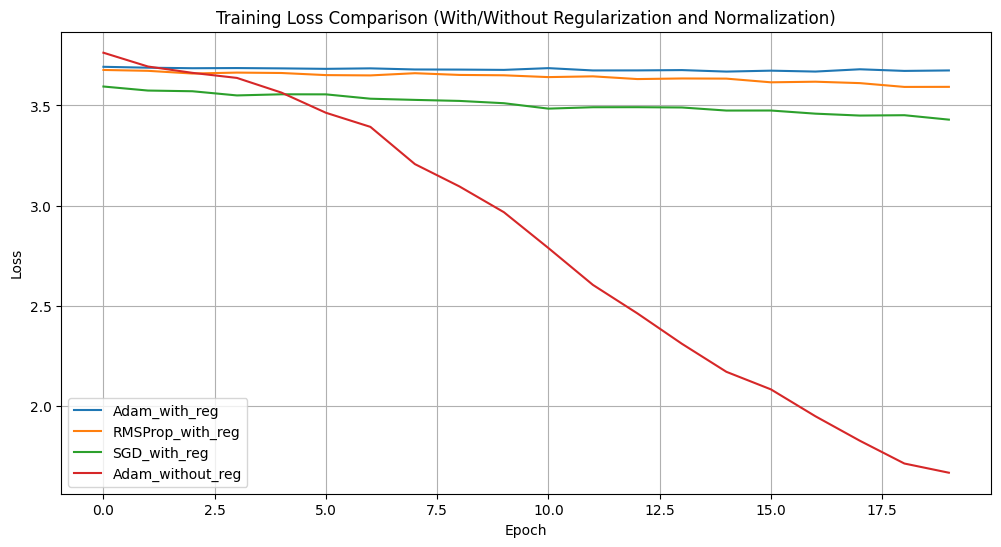

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# 1. 数据加载与预处理
datasets_path = "../../../../datasets_data/faces_data"
olivetti_faces = fetch_openml(
    name='olivetti_faces',
    data_home=datasets_path,
    version=1,
    as_frame=False
)
face_data, face_target = olivetti_faces.data, olivetti_faces.target

# 原始数据（归一化）
X_normalized = torch.tensor(face_data, dtype=torch.float32).view(-1, 64*64) / 255.0
y = torch.tensor(face_target.astype(int), dtype=torch.long)

# 对照实验数据（不归一化）
X_raw = torch.tensor(face_data, dtype=torch.float32).view(-1, 64*64)

# 划分训练验证集
X_train_norm, X_val_norm, y_train, y_val = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42
)
X_train_raw, X_val_raw, _, _ = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

# 创建数据加载器
train_loader_norm = DataLoader(TensorDataset(X_train_norm, y_train), batch_size=10, shuffle=True)
train_loader_raw = DataLoader(TensorDataset(X_train_raw, y_train), batch_size=10, shuffle=True)

# 2. 定义模型（新增无正则化对照模型）
class MLPClassifier(nn.Module):
    def __init__(self, use_dropout=True):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64*64, 128),
            nn.ReLU(),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),  # 条件使用Dropout
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(64, 40)
        )

    def forward(self, x):
        return self.layers(x)

# 原始模型（带正则化）
model_with_reg = MLPClassifier(use_dropout=True)
# 对照模型（无正则化）
model_without_reg = MLPClassifier(use_dropout=False)

# 3. 优化器配置（新增对照实验优化器）
criterion = nn.CrossEntropyLoss()
optimizers = {
    "Adam_with_reg": optim.Adam(model_with_reg.parameters(), lr=0.001),
    "RMSProp_with_reg": optim.RMSprop(model_with_reg.parameters(), lr=0.001),
    "SGD_with_reg": optim.SGD(model_with_reg.parameters(), lr=0.01, momentum=0.9),
    "Adam_without_reg": optim.Adam(model_without_reg.parameters(), lr=0.001)  # 对照实验优化器
}

# 4. 训练函数（保持不变）
def train_model(optimizer_name, num_epochs=20, use_norm=True):
    if "without_reg" in optimizer_name:
        model = model_without_reg
        loader = train_loader_raw if not use_norm else train_loader_norm
    else:
        model = model_with_reg
        loader = train_loader_norm

    optimizer = optimizers[optimizer_name]
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(loader.dataset)
        train_losses.append(epoch_loss)
        print(f"{optimizer_name} Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

    return train_losses

# 5. 更新可视化（新增对照实验曲线）
plt.figure(figsize=(12, 6))

# 训练所有模型
losses = {}
for optimizer_name in optimizers.keys():
    if "without_reg" in optimizer_name:
        losses[optimizer_name] = train_model(optimizer_name, num_epochs=20, use_norm=False)
    else:
        losses[optimizer_name] = train_model(optimizer_name, num_epochs=20)

# 绘制曲线
for name, loss in losses.items():
    plt.plot(loss, label=name)

plt.title("Training Loss Comparison (With/Without Regularization and Normalization)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()